# Example: Model Predictive Control 

In this example we will be using the **Static Market** model as well as the **Discrete Event Driven Simulation** (DEDS) egine.


(Data Enabled Predictive Control DeePC)

The main idea behind DeePC is to minimize/maximize an objective function given a prediction of the behaviour of a system and inputs.

The following assumptions will be made
1. The value of the asset can be approximated to its closing value at the end of the day.
1. The value of each asset is independent from the amount of shares we buy and sale.
1. The returns (as the proportional change in value with respect to the last day) of the asset can be approximated as a Linear Time Invariant system
1. The objective function to be optimized is the variance of the future returns, subject to a minimal expected return.

- Dataset: This example uses data containing Google and Apple stocks between Jan 1st 2017 and Jan 1st 2022.

> <span style="color:red">**Given some limitations on Julia visualization libraries some of the charts are presented in another notebook running Python**</span> 

In [1]:
# Setup the dependencies
using Pkg; Pkg.add("Suppressor"); using Suppressor: @suppress;
# @suppress Pkg.add(url="https://github.com/JuDO-dev/AirBorne.jl#dev");
@suppress Pkg.add(url="https://github.com/JuDO-dev/AirBorne.jl#mpc");
@suppress Pkg.add(["Dates","Plots","DataFrames", "DirectSearch","DotMaps","LinearAlgebra","Polynomials","SparseArrays","MathOptInterface"]);
# using Pkg;Pkg.add(["SparseArrays","MathOptInterface"]);
# @suppress Pkg.add(["Dates","PlotlyJS","DataFrames", "DirectSearch","DotMaps"]);
# @suppress Pkg.add(["Random","LinearAlgebra","Statistics","StatsPlots"]);

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Suppressor ─ v0.2.4
    Updating `~/.julia/environments/v1.8/Project.toml`
  [fd094767] + Suppressor v0.2.4
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [fd094767] + Suppressor v0.2.4
Precompiling project...
  ✓ Suppressor
  1 dependency successfully precompiled in 8 seconds. 216 already precompiled.


In [139]:

@suppress Pkg.add(url="https://github.com/JuDO-dev/AirBorne.jl#mpc");
# @suppress Pkg.add("AirBorne#mpc");

### DataSet A
This data contains Google and Apple stocks using data from Jan 1st 2017 until Jan 1st 2022.

In [2]:
using AirBorne.ETL.YFinance: get_interday_data
using Dates: DateTime,datetime2unix
using AirBorne.Structures: TimeEvent
# To generate this data use:
unix(x) = string(round(Int, datetime2unix(DateTime(x))))
data = get_interday_data(["AAPL","GOOG"], unix("2017-01-01"), unix("2022-01-01"))
evaluationEvents = [
        TimeEvent(t, "data_transfer") for t in sort(unique(data.date); rev=true)
    ]
first(data,4) # Display first 4 rows

Row,close,high,low,open,volume,date,unix,exchangeName,timezone,currency,symbol,assetID
,Float64,Float64,Float64,Float64,Int64,DateTime,Int64,String,String,String,String,String
1,29.0375,29.0825,28.69,28.95,115127600,2017-01-03T10:30:00,1483453800,NMS,America/New_York,USD,AAPL,NMS/AAPL
2,29.005,29.1275,28.9375,28.9625,84472400,2017-01-04T10:30:00,1483540200,NMS,America/New_York,USD,AAPL,NMS/AAPL
3,29.1525,29.215,28.9525,28.98,88774400,2017-01-05T10:30:00,1483626600,NMS,America/New_York,USD,AAPL,NMS/AAPL
4,29.4775,29.54,29.1175,29.195,127007600,2017-01-06T10:30:00,1483713000,NMS,America/New_York,USD,AAPL,NMS/AAPL


# Single index trajectory forecast

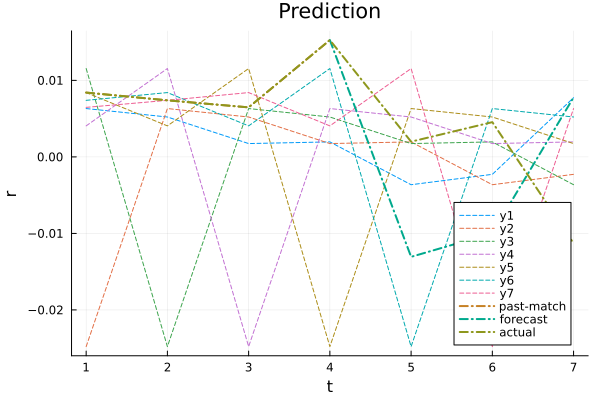

In [4]:
# using Plots: plot, plot!
using AirBorne.ETL.AssetValuation: returns

function matchTrajectory(Y,y_ini)
    Yp = Y[1:length(y_ini),:] # Past-matching segments
    Yf = Y[length(y_ini)+1:end,:] # Future-matching segments
    g = Yp\y_ini # Least Square
    y_fut = Yf*g
    return y_fut, g
end
data_goog = data[data[!,"symbol"].=="GOOG",:]
Y_all = Vector{Float64}(returns(data_goog.close))
p=4
f=3
N=p+f
t = 100
Y= Matrix{Float64}(undef, N, N)
y_ini = Y_all[t-p+1:t]
for i=1:N
 Y[i,:]= Y_all[t-i-N+1:t-i] 
end

Yp = Y[1:length(y_ini),:] # Past-matching segments
Yf = Y[length(y_ini)+1:end,:] # Future-matching segments
g = Yp\y_ini # Least square weigths estimation
y_fut = Yf*g # Expected returns
yVar_fut = (((Yf .-y_fut)*g).^2)./(length(g)-1) # Variance on prediction 

plot(1:N,Y, title="Prediction", xlabel="t", ylabel="r", linestyle=:dash )  
plot!(1:p,Yp*g, label="past-match", xlabel="t", ylabel="r", linestyle=:dashdot, linewidth=2 ) 
plot!(p:N,[y_ini[end]; y_fut[:]], label="forecast", xlabel="t", ylabel="r", linestyle=:dashdot, linewidth=2 ) 
plot!(1:N,Y_all[t-p+1:t+f], label="actual", xlabel="t", ylabel="r", linestyle=:dashdot, linewidth=2 )
# plot!(1:p,y_ini, label="past", xlabel="t", ylabel="r", linestyle=:dashdot, linewidth=2 )

# Multi index trajectory forecast
So far the trajectory prediction relies on forming an invertible matrix for to match the past values and then taking the weigths on the future values to make the forecast. 

### Covariance definition
This  will come into play later.
$$
Cov(X,Y)=E[(X−EX)(Y−EY)]
$$

# Example

Now suppose we have 2 assets, we have 2 options, we want to use 2 elements of the past data to predict 1 of future data. The assets are A and G (Apple and Google) and its value at a given time is represented by a subindex.
1. We forecast them separately
2. We forecast them toghether

### Case 1: Forecast asset value separately
This requires the same amount of historical data, however there is no clear connection  between the covariancce of the future trajectories. Lets examine Apple for example, here we will have 2 trajectories and a set of weigths **g** that matches the past and are used to predict the future. Moreover we can model g as a probability of the path rather than a composition and thus be able to calculate the variance at each individual time in the future. 

$$
A = \begin{bmatrix} A_1 & A_2\\ A_2 & A_3 \\  A_3 & A_4 \end{bmatrix} 
$$
$$
A_p*g=\begin{bmatrix} A_1 & A_2\\ A_2 & A_3 \end{bmatrix} * g = \begin{bmatrix} A_4 \\ A_5 \end{bmatrix} 
$$

$$
g=A_p^{-1}\begin{bmatrix} A_4 \\ A_5 \end{bmatrix} 
$$
$$
A_5^*=A_f*g = \begin{bmatrix} A_3 & A_4 \end{bmatrix}  *g
$$
> **Pros:** We have a notion of mean and variance at each point in the future for each asset value. Therefore we can define an optimal control problem with this

> **Con**: **Covariance is ill defined**-  Is not straight forward that if we have 2 predictions obtained in this way A_5* G_5* to be able to associate a covariance between the two random variables forecasting A_5 and G_5. **Without negative covariances the optimal solution using the markowitz criteria is to invest everything in the asset with least variance given a specific return, or a combination between the most profitable and the one with the least variance.**

### Case 2: Forecast asset value toghether
If one does it together on the other hand the amount of time samples to look into the past grows  significantly. Observe that the hankel matrix from stacking on top of each other A and B are is now of size 3*2 this means that the number of rows we will obtain is equal to  the full-horizon length times the number of assets being forecasted toghether.

$$
H_{1,2} = \begin{bmatrix} 
            A_1 & A_2\\
            A_2 & A_3\\
            A_3 & A_4\\
            B_1 & B_2\\
            B_2 & B_3\\
            B_3 & B_4\\ 
            \end{bmatrix} 
$$

Shuffling the rows around we cluster the past and future rows together by doing something like below. Where we can observe that the number of columns needed to obtain a past invertible matrix is equal to past-horizon times the number of assets forecasted togheter. 

> **Curse of dimensionality** Considering that there are more than 3000 assets retrievable by NASDAQ alone, just trying to forecast the next day by using 2 days in the past having full cross-correlation coverage implies having to use more than 10 years of past data, moreover consider that assets that were once correlated now may not be and assets now correlated may not have been before and not all assets existed 10 years ago, the problem becomes absurd from a contextual  point of view.

**Then the problem becomes:**
$$
H_{1,2} = \begin{bmatrix} 
            A_1 & A_2 & A_3 & A_4 \\
            B_1 & B_2 & B_3 & B_4 \\
            A_2 & A_3 & A_4 & A_5 \\
            B_2 & B_3 & B_4 & B_5 \\\hline
            A_3 & A_4 & A_5 & A_6 \\ 
            B_3 & B_4 & B_5 & B_6 \\ 
            \end{bmatrix} 
$$

$$
H_p*g=\begin{bmatrix} 
            A_1 & A_2 & A_3 & A_4 \\
            B_1 & B_2 & B_3 & B_4 \\
            A_2 & A_3 & A_4 & A_5 \\
            B_2 & B_3 & B_4 & B_5 \\\end{bmatrix} * g = \begin{bmatrix} 
A_5 \\
B_5 \\
A_6 \\
B_6 \\ \end{bmatrix} 
$$

$$
\begin{bmatrix} A_7^* \\ B_7^* \end{bmatrix}=H_f*g = \begin{bmatrix}A_3 & A_4 & A_5 & A_6 \\ B_3 & B_4 & B_5 & B_6 \\  \end{bmatrix}  * g
$$

With this definition one can calculate the covariance of the trajectories using the traditional formula of the covariance.

> **Challenge:** If Markowitz can calculate the variance and co-variance of a static distribution of the returns of assets using at least 2 values in the past for the next one, how can we using the same amount of information also establish some sort of covariance relation between the trajectories?


### Case 3 (Not conviced yet): Forecast separately and aggregate future values into mean vector and covariance matrix
I could in principle forecast separately, establish an average return vector and covariance matrix from each individual prediction, and used that as the source of a Markowitz problem, instead of past data it would be based on the series of future predicitons. However I do not have a  solid statistical argument to backup this method.

> **Nuances on Optimal Control**: Even if this method works, by assuming that correlations in the past are going to be carried forward into the forecasts. When doing the Markwoitz problem all the timeseries forecasted data will be aggregated into average and variance parameters. Raising the question, **What is the cost function of the optimal control problem?**

### Case 4 (Not conviced yet): Forcasting the covariance matrices?
Can we at each iteration calculate the markowitz covariance matrix  and predict how is going to change the terms in the covariance and return matrices? Is this actually going to benefit us somehow? 
- If there are no fees it may not make a difference as the cost of transforming the portfolio is 0. If the objective were to be given a expected return minimize variance. 
- If there are fees involved it may make a difference as it can account for the costs of transforming the portfolio. In this case we need to calculate the returns and accumulated returns

> **Pros:** This has a well defined objective function!

>

In [5]:
using AirBorne.ETL.AssetValuation:
    stockValuation, covariance, returns
sv = stockValuation(data)
rv = returns(sv)
assetIDs= [n for n in names(rv) if !(n in["date","stockReturns"])]
rv_data = rv[!,assetIDs]
sv_data = sv[!,assetIDs]

Row,NMS/AAPL,NMS/GOOG
,Float64?,Float64?
1,29.0375,39.307
2,29.005,39.345
3,29.1525,39.701
4,29.4775,40.3075
5,29.7475,40.3325
6,29.7775,40.2395
7,29.9375,40.3955
8,29.8125,40.318
9,29.76,40.394


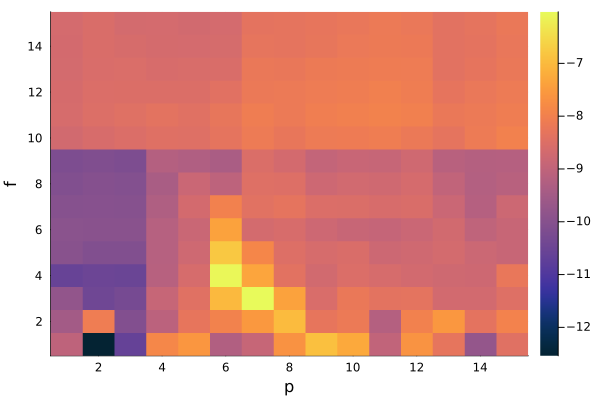

In [42]:
using AirBorne.ETL.AssetValuation:
    stockValuation, covariance, returns
using DataFrames: DataFrame

t=100
stock_ix=1
p=5 # Past Values
f=3 # Future Values


"""
    Predicts trajectory using the Behavioural method.
"""
function behaviouralPred(d,p,f; Ys=nothing)
    N=p+f
    if isnothing(Ys)
        Y_all = Vector{Float64}(d)
        Y= Matrix{Float64}(undef, N, N)
    else 
        Y=Ys
    end
    t = length(d)
    y_ini = Y_all[t-p+1:t]
    for i=1:N
     Y[i,:]= Y_all[t-i-N+1:t-i] 
    end

    Yp = Y[1:length(y_ini),:] # Past-matching segments
    Yf = Y[length(y_ini)+1:end,:] # Future-matching segments
    g = Yp\y_ini # Least square weigths estimation
    y_fut = Yf*g # Expected returns
    return y_fut
end
function behaviouralPredDF(df::DataFrame, p::Int64,f::Int64;cols::Union{Vector{String},Nothing}=nothing)
    out = DataFrame()
    cols = isnothing(cols) ? names(rv_data) : cols
    for col=cols
        out[!,col] = behaviouralPred(df[1:t,col],p,f)
    end
    return out
end

function behaviouralLMSE(p,f)
    # Test Forecast
    fun(x) = behaviouralPredDF(x,p,f) 

    source = rv_data
    forecast = fun(source[1:t,:])
    lookahead = size(forecast,1)
    actual = source[t+1:t+lookahead,:]
    # Absolute error
    LMSE = log(sum((Matrix(forecast) - Matrix(actual)).^2) / prod(size(Matrix(forecast))))
    return LMSE 
end
# Forecast from 2018 onward
# 2017 will be used solely for training to standarize output and measures

heatmap(1:15, 1:15, behaviouralLMSE, c = :thermal, xlabel="p", ylabel="f")

# 2 of past and 1 of future seems to work best. 

# Forecasts

The forecasts in this example are functions of the form: 
$$R^{N_p \times n} \rightarrow R^{N_f \times n}$$

Given N_p datapoints from the past they produce the immediate N_f datapoints from the future, each datapoint consists of n elements, in the following examples each element correspond to the return of an asset. Therefore forecast matrix has one row per time, and one column per assetID.

In [159]:
using DataFrames: DataFrame
using Polynomials: fit

function genData(data::DataFrame,t;N_p::Union{Nothing,Int64}=nothing)
   return isnothing(N_p) ?  data[1:t,:] : data[t-N_p+1:t,:]      
end

function genActual(data::DataFrame,t,N_f)
    return data[t+1:t+N_f,:] 
end

function lastValForecast(data,N_f)
    forecast=DataFrame()
    last_val=data[end,:]
    [push!(forecast,last_val) for i=1:N_f]
    return forecast
end

function polyFitForecast(data,N_p,N_f;order::Int64=1)
    x = 1:N_p # Assume equidistant points
    xf = N_p+1: N_p+N_f
    out = DataFrame()
    for col=names(data) # For each column
        poly=fit(x,float.(data[end-N_p+1:end,col]),1)
        out[!,col]=poly.(xf)
    end
    return out
end

# Each stock is forecasted separatedly
function behaviouralForecast_A(data,N_p,N_f; calc_var::Bool=false)
    N=N_p+N_f
    Y= Matrix{Float64}(undef, N, N)
    out = DataFrame()
    
    for col=names(data) # For each column
        Y_all = float.(data[!,col])
        y_ini = Y_all[end-N_p+1:end] # Initial conditions to be matched
        for i=1:N
            Y[i,:]= Y_all[end-i-N+1:end-i] 
        end
        Yp = Y[1:N_p,:] # Past-matching segments
        Yf = Y[N_p+1:end,:] # Future-matching segments
        g = Yp\y_ini # Least square weigths estimation of past trajectory        
        out[!,col]=Yf*g # Composition leading to future trajectory
        if calc_var
        out[!,"VAR__" * col] = (((Yf .-out[!,col])*g).^2)./(length(g)-1) # Variance on prediction 
        end
    end
    return out
end

# Forecasts tests (Pass to Unit Tests)
t = 100
N_p = 30
N_f = 15
filtered_data = genData(rv_data,t;N_p=N_p)
filtered_data2 = genData(rv_data,t)
actual = genActual(rv_data,t,N_f)
forecast_lastVal = lastValForecast(filtered_data,N_f)
forecast_linReg = polyFitForecast(filtered_data,3,N_f)
forecast_behavioural = behaviouralForecast_A(filtered_data2,N_p,N_f;calc_var=true)
@info "Done"
# @info size(rv_data)
# @info size(filtered_data)
# @info size(actual)
# @info size(forecast_lastVal)
# @info size(forecast_behavioural)



[ Info: Done


### Forecast performance tests

In [139]:
using Statistics: mean
"""
    Logarithmic Mean Squared Error

    Each row is a different data point.
    Each columns correspond to dimension of the datapoints.

    Calculates the squared error between the forecast and the actual accross all datapoints 
    and normalizes by dividing over the number of datapoints times the dimensions.

    Lastly applies Log10 to the result.
"""
function LMSE(actual::DataFrame,forecast::DataFrame)
    return  log(sum((Matrix(forecast) - Matrix(actual)).^2) / prod(size(Matrix(forecast))))
end

"
    Logarithmic squared error (LSE)

    Each row is a different data point.
    Each columns correspond to dimension of the datapoints.

    Calculates for each datapoint the Log10 of the squared error between the forecast and the actual.
"
function LSE(actual::DataFrame,forecast::DataFrame) 
   return log.(mean((Matrix(forecast) - Matrix(actual)).^2,dims=2))
end
@info "Done"



[ Info: Done


In [98]:
# Error Calculations
t = 100
N_p = 30
N_f = 15

LVF(data) = lastValForecast(data,N_f)
LRF(data) = polyFitForecast(data,N_p,N_f;order=1)
BHF(data) = behaviouralForecast_A(data,N_p,N_f; calc_var=false)
forecast_pairs= [("LV",LVF), ("LR",LRF),("BH",BHF)]

start_ix = findfirst(==(DateTime("2018-01-03T10:30:00")), rv.date)
end_ix = size(rv.date,1)-N_f
i = start_ix 

R_LSE=[]
R_LMSE=[]
for i=start_ix:end_ix #start_ix+2
    flush(stdout);print((i-start_ix)/(end_ix-start_ix));print("\r")
    source= genData(rv_data,i)
    actual = genActual(rv_data,i,N_f)
    i_forecasts = Dict([fp[1]=>fp[2](source) for fp in forecast_pairs])
    push!(R_LSE, Dict([key=>LSE(actual,value)' for (key, value) in i_forecasts]))
    push!(R_LMSE, Dict([key=>LMSE(actual,value) for (key, value) in i_forecasts]))
end


#### LMSE Analysis
The **LMSE** is the **L**og10 of the **Mean** **S**quared **E**rror of a forecast over the forecasted horizon.

It can be seen that "Linear Regression" (**LR**) is in general significatively more accurate than "Last Value"(**LV**) and "Behavioural"(**BH**) approaches, where **BH** is the worst performant.

However **LV** shows greater variance and higher extreme values than the other methods.

[ Info: Mean(LR-LMSE):-8.04264833274971
[ Info: Mean(BH-LMSE):-7.506721239167692
[ Info: Mean(LV-LMSE):-7.682152475652974


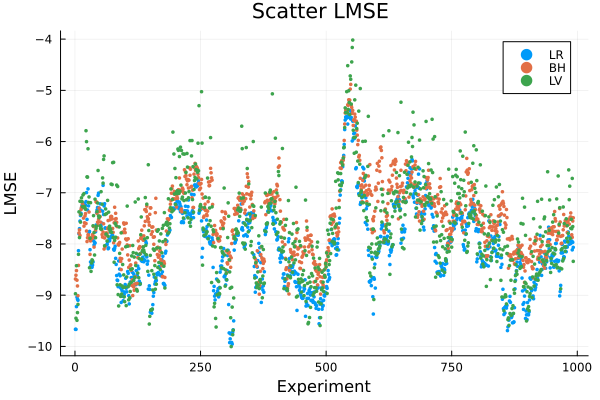

In [158]:
using Plots:  scatter
using Statistics: mean, median


df_LMSE=DataFrame(R_LMSE)
for key=names(df_LMSE)
@info "Mean($(key)-LMSE):$(mean(df_LMSE[!,key]))"
end
# LSE_Heatmaps = Dict([key=> countMatrix(reduce(vcat, df_LSE[!,key])) for key=names(df_LSE)])

# means_LSE=[mean(reduce(vcat, df_LSE[!,key]),dims=1) for key=names(df_LSE)]
scatter(1:size(df_LMSE,1),
    [df_LMSE[!,key] for key=names(df_LMSE)],label=reshape(names(df_LMSE),1,:),
    title="Scatter LMSE ", xlabel="Experiment", ylabel="LMSE", ms=2,msw=0 #,lw=0.01
    # markersize=0.5, color=[:red :green :blue],
)


#### LSE Analysis

The **LSE** is the **L**og10 of the **S**quared **E**rror of a forecast of a particular datapoint, the Mean LSE is the average LSE of all experiments at a over a particular distance in time into the future.  

It can be seen that "Linear Regression" (**LR**) is in general significatively more accurate than "Last Value"(**LV**) and "Behavioural"(**BH**) approaches, where **BH** is the worst performant. Moreover **LR** is the only forecast that consistently gets worse the furter into the future, albeit this trend is clear when observing the mean is not so when observing the distribution of the error.


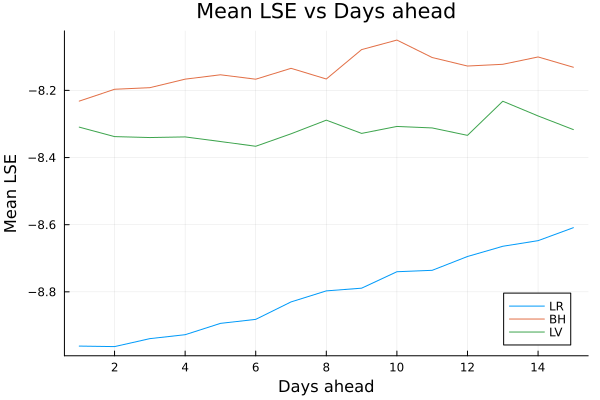

In [277]:
using Plots: heatmap, plot, plot!
using Statistics: mean, median
function countMatrix(res_Mx::Matrix;step::Real=0.5)
    m,_ = findmin(res_Mx)
    M,_ = findmax(res_Mx)
    thresholds = collect(floor(m):step:ceil(M))
    NumExperiments,MaxHorizon = size(Matrix(res_Mx))
    vizMat = zeros((length(thresholds),size(res_Mx,2)))
    for i = 2:length(thresholds)
        for col=1:size(res_Mx,2)
            c = sum((res_Mx[:,col].>=thresholds[i-1]) .&& (res_Mx[:,col].<thresholds[i])) 
            vizMat[i,col] = c / NumExperiments
        end     
    end
    return vizMat, thresholds
end

df_LSE=DataFrame(R_LSE)
LSE_Heatmaps = Dict([key=> countMatrix(reduce(vcat, df_LSE[!,key])) for key=names(df_LSE)])

means_LSE=[mean(reduce(vcat, df_LSE[!,key]),dims=1) for key=names(df_LSE)]
plot(1:15,
    [mean(reduce(vcat, df_LSE[!,key]),dims=1)[:] for key=names(df_LSE)],label=reshape(names(df_LSE),1,:),
    title="Mean LSE vs Days ahead", xlabel="Days ahead", ylabel="Mean LSE"
)


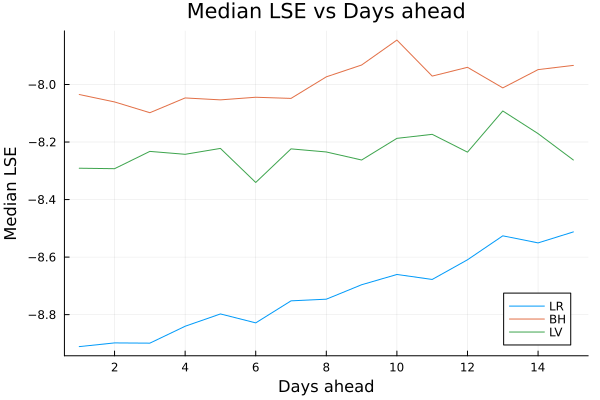

In [278]:
plot(1:15,
    [median(reduce(vcat, df_LSE[!,key]),dims=1)[:] for key=names(df_LSE)],label=reshape(names(df_LSE),1,:),
    title="Median LSE vs Days ahead", xlabel="Days ahead", ylabel="Median LSE"
)

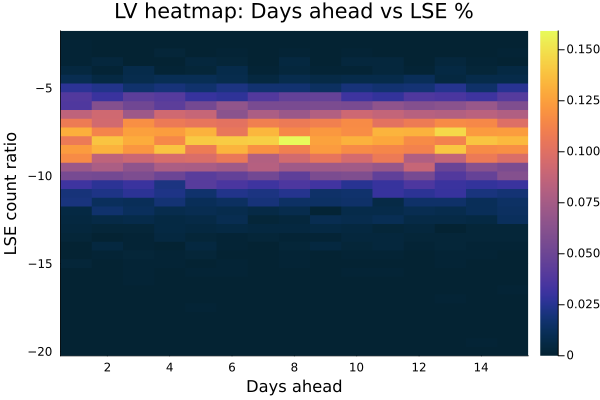

In [279]:
key = "LV"
vizMat = LSE_Heatmaps[key][1]
thresholds = LSE_Heatmaps[key][2]
heatmap(1:size(vizMat,2),thresholds, vizMat,c=:thermal, xlabel="Days ahead",
    ylabel="LSE count ratio",title="$(key) heatmap: Days ahead vs LSE %")

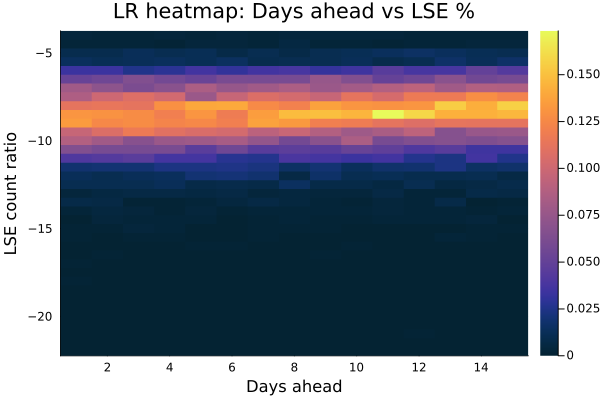

In [280]:
key = "LR"
vizMat = LSE_Heatmaps[key][1]
thresholds = LSE_Heatmaps[key][2]
heatmap(1:size(vizMat,2),thresholds, vizMat,c=:thermal, xlabel="Days ahead",
    ylabel="LSE count ratio",title="$(key) heatmap: Days ahead vs LSE %")

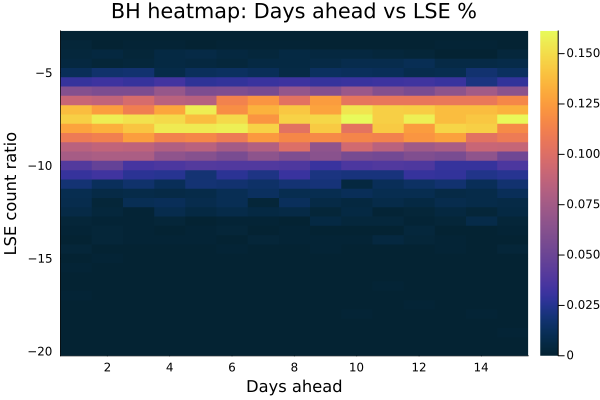

In [281]:
key = "BH"
vizMat = LSE_Heatmaps[key][1]
thresholds = LSE_Heatmaps[key][2]
heatmap(1:size(vizMat,2),thresholds, vizMat,c=:thermal, xlabel="Days ahead",
    ylabel="LSE count ratio",title="$(key) heatmap: Days ahead vs LSE %")

# Simulation

In [4]:
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data
using AirBorne.Strategies.Markowitz: initialize!, trading_logic!
using Dates: DateTime

my_expose_data(context,data) = expose_data(context,data; historical=false)
@time context = run(
    data,
    initialize!,
    trading_logic!,
    execute_orders!,
    my_expose_data;
    audit=true,
    max_date=DateTime(2022, 1, 1),
    verbose=true,
    initialEvents=evaluationEvents,
)
@info "done"

 66.728474 seconds (77.87 M allocations: 4.642 GiB, 4.21% gc time, 59.52% compilation time: 4% of which was recompilation)


[ Info: done


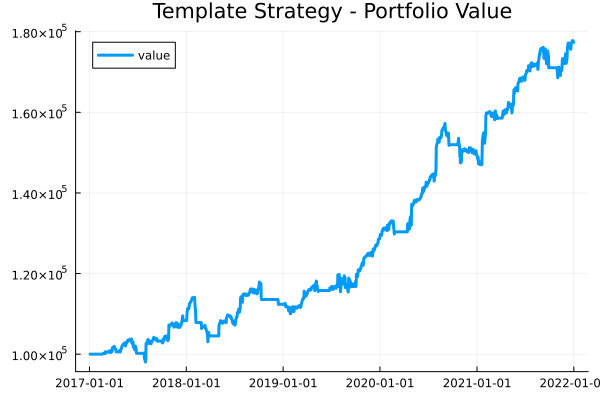

In [5]:
using AirBorne.Structures: summarizePerformance
using Plots: plot
results = summarizePerformance(data, context)
plot(results.date, results.dollarValue, title="Template Strategy - Portfolio Value", label="value", linewidth=3)

## Building Optimization maximizing return given return forecast considering constant and/or proportional fees
This strategy assumes that at any point in the future in a given horizon one is able to estimate the daily return and 
that a model of the fee structure is present that is either proportional to the value of a purchase/sell or of a fixed amount per transaction.

Given a horizon this strategy will select the portfolio distribution over time that maximizes the over return.
<!--  of the compound expected returns along with the compound expected variance modelling the returns 
as a stochastic process made from Gaussian distributions. -->


## Building Optimization with Expected Return and Covariance Matrix Forecast
This strategy assumes that at any point in the future in a given horizon one is able to estimate the values of the compound expected returns along with the compound expected variance modelling the returns 
as a stochastic process made from Gaussian distributions.

Given a horizon this strategy will select the portfolio distribution over time that maxmimizes the return over the accumulated variance.

Given that the return from one day to the next is assumed to be modelled by a Multivariate Gaussian with mean mu and covariance sigma, and the distribution of returns between one day and the next are assumed independent. The total expected return is given compunding as well as the variance?

$$GR_1=G(\mu_1,\Sigma_1):\text{Multivariate-distribution representing the return from one day 1 to day 2}$$
$$GR_2=G(\mu_2,\Sigma_2):\text{Multivariate-distribution representing the return from one day 2 to day 3}$$
$$\vdots$$
$$GR_N=G(\mu_N,\Sigma_N):\text{Multivariate-distribution representing the return from one day N to day N+1}$$

**Expected return definition**

$$X_1: \text{Portfolio distribution on day 1}$$
$$X_2: \text{Portfolio distribution on day 2}$$
$$r_{1,2}=X_1*\mu_1:\text{Expected return from day 1 to 2}$$
$$r_{2,3}=X_2*\mu_2:\text{Expected return from day 2 to 3}$$

**Multi-period expected return definition:**

Using the assumption of independent returns the expected growth of a portfolio value is over periods 1 and 2 are: 
$$(1+r_{1,2})\text{ and } (1+r_{2,3})$$
And the overall growth between both periods is
$$r_{1,3}=(1+r_{1,2})*(1+r_{2,3})-1$$
Or more generally for any sequence of periods can be written as:
$$r_{1,N}=\prod_{i=1}^{N-1}(1+r_{i,i+1})-1$$



In [17]:
using AirBorne.Utils: sortedStructInsert!
using AirBorne.Structures: ContextTypeA, TimeEvent
using AirBorne.Markets.StaticMarket: Order, place_order!
using AirBorne.ETL.AssetValuation: stockValuation, returns, covariance
using Dates: Day, year
using DataFrames: DataFrame, groupby, combine, mean, Not
using DotMaps: DotMap
using DirectSearch: 
    DSProblem, Optimize!, SetInitialPoint, SetObjective, SetIterationLimit, SetGranularity, AddExtremeConstraint, AddProgressiveConstraint
using Suppressor: @suppress;
using LinearAlgebra: kron, I

function custom_initialize!(context::ContextTypeA; 
        future_horizon::Int64=5, past_horizon::Int64=5,
        y_dimension::Int64=1,
        initialCapital::Real=10^5, min_growth::Real=0.001)
    
    ###################################
    ####  Parameters & Structures  ####
    ###################################
    context.extra.future_horizon = future_horizon
    context.extra.past_horizon = past_horizon
    
    n_columns = size(u_ini)[1]*m+ size(y_ini)[1]*p;
    # context.extra.R = kron(I(future_horizon),0.25) # Only used if input affects output
    context.extra.Q = kron(I(future_horizon),100)
    
    # context.extra.HLu =zeros((N+T_ini)*m,n_columns)
    context.extra.HLy =zeros((N+T_ini)*y_dimension,n_columns) 
    
    context.extra.valueHistory=DataFrame()
    context.extra.returnHistory=DataFrame()
    context.extra.currentValue=DataFrame()
    context.extra.pastValue=DataFrame()
    
    context.extra.idealPortfolioDistribution =[]
    context.extra.min_growth=min_growth
    
    ###################################
    ####  Specify Account Balance  ####
    ###################################
    context.accounts.usd = DotMap(Dict())
    context.accounts.usd.balance = initialCapital
    context.accounts.usd.currency = "USD"
    
    return nothing
end

function custom_trading_logic!(context::ContextTypeA, data::DataFrame; tune_parameters::Dict=Dict())
    #######################
    ####  Update data  ####
    #######################
    if size(data,1)==0 # No New data, nothing to do
        return nothing 
    end
    context.extra.pastValue=context.extra.currentValue
    context.extra.currentValue=stockValuation(data)
    [push!(context.extra.valueHistory,r) for r=eachrow(context.extra.currentValue)]
    
    if size(context.extra.pastValue,1)>0 # Add new data to history record
        r1 = returns(vcat(context.extra.pastValue,context.extra.currentValue))
        push!(context.extra.returnHistory,r1[end,:])
    end

    
    ################################
    ####  Calculate Statistics  ####
    ################################
    if size(context.extra.returnHistory,1)<context.extra.horizon
        return nothing # Not enough history data to 
    end
    d = context.extra.returnHistory[end-context.extra.horizon+1:end,:]
    M = covariance(d) # Covariance Matrix
    m = mean(Matrix(d[!,Not(["date","stockReturns"])]),dims=1)
    max_return,ix = findmax(m)
    
    ######################################
    ####  Solve Optimization problem  ####
    ######################################
    if max_return>context.extra.min_growth # Feasible problem
        if context.extra.idealPortfolioDistribution==[]
            initial_point = zeros(size(m))
            initial_point[ix]=1.0
        else
            initial_point = context.extra.idealPortfolioDistribution 
        end

        upper_cons(x) = all(x .<= 1) 
        lower_cons(x) = all(x .>= 0) 
        min_return(x) = context.extra.min_growth-(m*x)[1] # I want at least a 0.1% return in 1 day 
        obj(x) = x'*M*x 

        p = DSProblem(length(m))
        SetGranularity(p, Dict( [i => 0.001 for i=1:length(m)] ))
        SetObjective(p,obj)
        AddProgressiveConstraint(p, min_return)
        AddExtremeConstraint(p, upper_cons)
        AddExtremeConstraint(p, lower_cons)
        SetInitialPoint(p,vec([ i for i =initial_point]))
        @suppress Optimize!(p)
        context.extra.idealPortfolioDistribution = isnothing(p.x) ? zeros(size(m)) : p.x
    else
        context.extra.idealPortfolioDistribution = zeros(size(m)) # Sell absolutely everytihng. Market is going down.
    end
          
    #######################################################
    ####  Calculate Difference with Optimal Portfolio  ####
    #######################################################
    asset_names = names(context.extra.currentValue)[2:end-1]
    cv=reshape(Matrix(context.extra.currentValue)[2:end-1], (length(asset_names))) # Current value per share for ticker
    if length(context.portfolio)==0 # Obtain vector with current portfolio
        context.portfolio = Dict([name=>0.0 for name in names(context.extra.currentValue)][2:end-1])
    end
    currentPortfolio = reshape(Matrix(DataFrame(context.portfolio)), (length(asset_names)))
    total_capital = context.accounts.usd.balance + (currentPortfolio'*cv)[1] # Total capital to distribute 
    
    # Amount of shares to have of each ticker
    nextPortfolio =  reshape([context.extra.idealPortfolioDistribution[i] * total_capital / cv[i] for i=1:length(cv)], (length(asset_names)))
    
    # Amount of shares to buy/sell of each ticker
    portfolioDiff=nextPortfolio-currentPortfolio
      
    ########################################
    ####  Summaryze and produce orders  ####
    ########################################
    diffDf=DataFrame(Dict(["symbol"=>asset_names,"diff"=>portfolioDiff,"cv"=>cv]))
    diffDf[!,"total"]= diffDf.diff.*diffDf.cv
    diffDf=diffDf[diffDf.diff.!=0,:] # Keep only non-zero values
    sort!(diffDf[diffDf.diff.!=0,:],:total) # Sort such that largest sells happen first, and largest buy's later
    for r=eachrow(diffDf) # Produce and place orders
            market,ticker= split(r.symbol,"/")
            order_specs = DotMap(Dict())
            order_specs.ticker = String(ticker)
            order_specs.shares = r.diff # Number of shares to buy/sell
            order_specs.type = "MarketOrder"
            order_specs.account = context.accounts.usd
            order = Order(String(market), order_specs)
            place_order!(context,order) 
    end
    return nothing
end


custom_trading_logic! (generic function with 1 method)

### The Prediction Model
### DeePC Algorithm
The algorithm below is presented for LTI systems with an unkown model, this is a system defined by the equation below where the matrices A, B, C, D are unknown.

$$
\left\{
    \begin{array}\\
        x(t+1)= A x(t) + B  u(t)) \\
        y(t)= C x(t) + D u(t)\\
        \end{array}
\right.
$$

The DeePC algorithm intends to solve the Optimal Control Problem below:

$$
\min_{g,u,y} 
    \sum_{k=0}^{N-1}\left(|y_k-r_{t+k}|_Q^2 + |u_k|_R^2\right)  \\
    s.t.\\
\begin{pmatrix} U_p \\ Y_p \\ U_f \\ Y_f \end{pmatrix} * g = \begin{pmatrix} u_{ini} \\ y_{ini} \\ u \\ y \end{pmatrix}
    $$

- $u$ and $y$ are not independent decision variables , they are defined by the matrices $U_f$ and  $Y_f$
- The decision variable is just $g$ because we can define u and y as follows
$$u=U_fg\\y=Y_fg$$

Then the problem becomes:

$$\min_g \sum_{k=0}^{N-1} \left(|\left(Y_fg\right)_k-r_{t+k}|_Q^2 +\left(U_fg\right)_k|_R^2    \right) $$
    
$$    s.t.\\
\begin{pmatrix} U_p \\ Y_p \end{pmatrix} * g = \begin{pmatrix} u_{ini} \\ y_{ini} \end{pmatrix}$$

##### Hankel Matrix
- $L$
- $T$ with $T \geq L $
$$H_L(u)= \begin{Bmatrix}
u_1 & \cdots & u_{T-L+1}\\
\vdots & \ddots & \vdots\\
u_L & \cdots & u_T
\end{Bmatrix}$$
- $H_L(u)$ needs to be full row rank for u to be persistently exiting of order L, meaning that all the rows of $H_L(u)$ need to be independent.

In [18]:
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data
using AirBorne.Structures: summarizePerformance
using Dates: DateTime
evaluationEvents = [
        TimeEvent(t, "data_transfer") for t in sort(unique(data.date); rev=true)
    ]
my_expose_data(context,data) = expose_data(context,data; historical=false)
@time custom_context = run(
    data,
    custom_initialize!,
    custom_trading_logic!,
    execute_orders!,
    my_expose_data;
    audit=true,
    max_date=DateTime(2022, 1, 1),
    verbose=true,
    initialEvents=evaluationEvents,
)
@info "done"

 35.332705 seconds (40.43 M allocations: 2.627 GiB, 2.79% gc time, 5.59% compilation time: 58% of which was recompilation)


[ Info: done


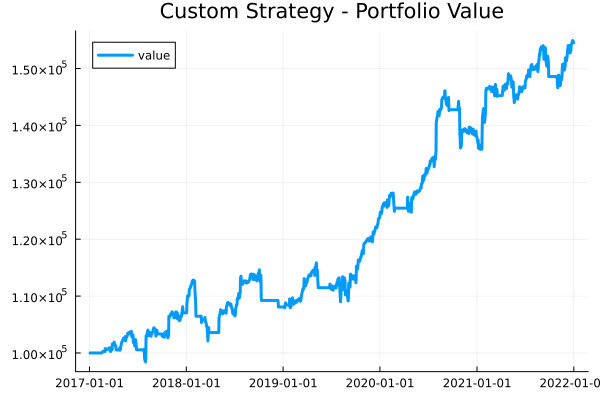

In [19]:
using AirBorne.Structures: summarizePerformance
using Plots: plot
results = summarizePerformance(data, custom_context)
plot(results.date, results.dollarValue, title="Custom Strategy - Portfolio Value", label="value", linewidth=3)

# Testing against an ARMAX Model

Since it is out of the scope of this example to prove, or disprove the LTI assumption. This model can also be tested against an  **A**uto**R**egressive **M**oving **A**verage e**X**ogeneous(ARMAX) model, which is LTI.

This system shall be an ARMAX process, this is a Linear Time Invariant system governed by the following transfer function.

$$A(z) y(t) = C(z) e(t) + B(z) u(t)$$

- $y$: System Output
- $e$: Non-deterministic Noise
- $u$: System Input
- $A(z) = 1 + a_1 z^{-1} + a_2 z^{-2} ... $ 
- $B(z) = b_0 + b_1 z^{-1} + b_2 z^{-2} ... $ 
- $C(z) = c_0 + c_1 z^{-1} + c_2 z^{-2} ... $ 

Leaving us the time difference equation:

$$ y(t) = -\left(a_1 y(t-1) + a_2 y(t-2) +... +a_{na} y(t-na)\right)+... \\
c_0 * e(t) + c_1 * e(t-1)+ ... +  c_{nc} * e(t-nc)+ ... \\  
b_0 * u(t) + b_1 * u(t-1)+ ... +  b_{nb} * u(t-nb)  $$ 

- $u \in R^m$
- $y \in R^p $

For simplicity in this example we will focus on SISO systems. 

In [1]:
# Setup the dependencies
using Pkg; Pkg.add("Suppressor"); using Suppressor: @suppress;
@suppress Pkg.add(["Random","LinearAlgebra","Plots"]);

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


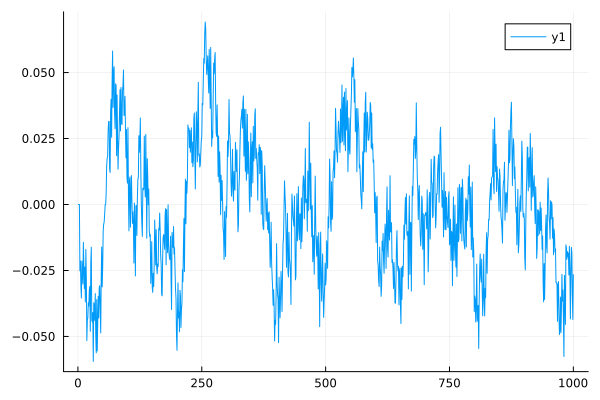

In [4]:
# ARMAX process generator
using Random: rand
using LinearAlgebra: dot
using Plots: plot

SimT=1000
na=3;nb=1;nc=3;
m=1;p=1;
# This model presents nice curves  
A_coeffs = [0.5, 0.25, 0.125]
B_coeffs = [0.40]
C_coeffs = [-0.21, -0.36, -0.013]

t=1:SimT
y = collect(t.*0.0) # Noise Generator
e = (rand(Float64, ( SimT)).-0.5)*0.1# Noise Generator
u = zeros(size(t) ) #rand(Float64, ( SimT)).-0.5 # Noise Generator
max_n = max(na,nb,nc)
for i in t
    y[i] = i>max_n ? dot(y[(i-na):(i-1)],A_coeffs) + dot(e[(i-nc+1):i],C_coeffs) + dot(u[(i-nb+1):i],B_coeffs) : 0
end

plot(t,y)


# MPC Strategy: Multi-period Portfolio Optimization

Two  formulations will be analyzed

- **Multi-Period Mean-Variance Non-compund:** This method tries to solve an QP problem were the cost functional has a negative quadratic term for each daily(transition) variance day and a positive linear term for returns.[1] By minimizing such cost functional a tradeoff between expected risk (variance) and expected returns is achieved, not in a ratio sense like optimizing sharpe but in opposing forces of a QP problem.  

<!-- - **Multi-Period Mean-Variance Compound:** This method addresses some (of what I consider) theoretical limitations observerd in the previous work in [1]. I do not agree with
    - **Not compounding returns in the cost functional:** Returns that you receive on the first day are re-invested in the following days. The solution to this problem I find by defining the **growth** as the ratio between the portfolio value on current day over the one of the day before(note that **growth=return+1**. Using this **growth**, and multiplying it with the rest one can get a closer notion of the overall return. Moreover if one applies a logarithmic to the growth, the problem becomes again a sum.
    - **Not compounding variance in the cost functional:** This relates to accounting for error propagation into the future -->
- **Risk-parity:** Is very likely I won't have enough time to fully develop this formulation also presented in [1], this formulation distributes the portfolio accross the whole market, but not homogenously (as in the efficient market formulation of Markowitz), but it distributes the value of the portfolio  accoring to a volatility matrix such that the marginal risk contribution of each asset in the portfolio is the same (meaning that given a volatily definition, inifinitesimally increasing the amount of any stock will provide the same increase in volatility).

> [1] Xiaoyue Li, A. Sinem Uysal, John M. Mulvey, 
> Multi-period portfolio optimization using model predictive control with mean-variance and risk parity frameworks,
> European Journal of Operational Research,
> Volume 299, Issue 3,
> 2022,
> Pages 1158-1176,
> ISSN 0377-2217,
> https://doi.org/10.1016/j.ejor.2021.10.002.
> (https://www.sciencedirect.com/science/article/pii/S037722172100847X)

## Formulation

$$
\max_{\pi_{t+1},...,\pi_{t+H}} \left(\sum_{\tau=t+1}^{\tau=t+H} \hat{r}^{T}_{\tau|t}\pi_{\tau} 
- \gamma^{risk}\left(\pi_{\tau}^T \hat{\Sigma}_{\tau|t}\pi_{\tau}\right) - 
- \gamma^{trade}||\pi_{\tau}-\pi_{\tau-1}||_1
\right)
$$
Subject to:
$$
\pi_{\tau}\geq 0\quad \forall\tau=t+1,...,t+H
$$
$$
\textbf{1}^T\pi_{\tau}=1 \quad \forall\tau=t+1,...,t+H
$$


Where
$$\hat{r}_{\tau|t}:\text{Estimation of the expected return vector at time }\tau \text{ given time up to  t} $$
$$\hat{\Sigma}_{\tau|t}:\text{Estimation of the covariance matrix at time } \tau \text{ given time up to  t}$$
$$\pi_{t+i}:\text{Distribution of portfolio value (accross assets) on time }t+i $$
$$\gamma^{risk}:\text{Risk aversion parameter}$$
$$\gamma^{trade}:\text{Transaction cost}$$

### Forecasting
As in the previous discussion this methods also use forecasting  to obtain the estatistical estimates of the future days. However the statistical properties such as the return vector and the covariance matrix are estimated through the tuning of Hidden Markov Models **HMM** looking through 2000 days into the past.

The reason of the long horizon is to be able to capture cyclical behaviours  and fit the model accordingly, this seasonal behaviours are known as regimes. The paper [1] claims that **HMM** could be used to descrieb a regime swithing behaviours, and that no more than 2 regimes are necessary to capture real market behaviour.



In [ ]:
# Float64.(tickers_df.ipoyear)
# Pre 2017 Symbols
using DataFrames: groupby, combine

########################################################
###    Pick the 5 most traded companies per sector   ###
########################################################
using AirBorne.ETL.NASDAQ: screener
using AirBorne.Utils: get_latest_N
tickers_df = screener()
filtered_df =tickers_df[[   x!="" ? parse(Int64, x)<2016 : false for x in tickers_df.ipoyear],["symbol","marketCap","sector","volume"]]
filtered_df[!,"volume"]=parse.(Int64,filtered_df[!,"volume"])
filtered_df[!,"marketCap"]=parse.(Float64,filtered_df[!,"marketCap"])
grouped_df = groupby(filtered_df,"sector")
f(sdf)= get_latest_N(sdf,:volume,5;rev=true)
result = combine(grouped_df,f)

#####################################################
###    Extract interday date from Yahoo Finance   ###
#####################################################
using AirBorne.ETL.Cache: store_bundle
bundle_id="Mark1"
cache_dir = joinpath(@__DIR__, "data", "cache")
# To generate the "demo" data use:
using AirBorne.ETL.YFinance: get_interday_data
using AirBorne.ETL.Cache: store_bundle
using Dates: DateTime, datetime2unix
from = DateTime("2017-01-01"); to = DateTime("2022-01-01")
u_from = string(round(Int, datetime2unix(from)));
u_to = string(round(Int, datetime2unix(to)))
data = get_interday_data(result.symbol, u_from, u_to)
store_bundle(data; bundle_id=bundle_id, archive=true, cache_dir=cache_dir)

In [1]:
using AirBorne.ETL.Cache: load_bundle
bundle_id="Mark1"
cache_dir = joinpath(@__DIR__, "data", "cache")
dataB=load_bundle(bundle_id;cache_dir=cache_dir)
using AirBorne.ETL.AssetValuation: stockValuation, returns
dollar_symbol = "FEX/USD"
sv=stockValuation(dataB)
sv[!,dollar_symbol].=1.0
sr=returns(sv)
@info "DataGenerated"

[ Info: DataGenerated


### Case 1: Perfect Forecasting

The first case to be analysed is the perfect forecasting, meaning that there is a method that is able to predict with 100% accuracy the dollar value which assets are to be traded.

This example has no notion of variance so the cost functional will be missing the variance minimization term. 
$$
\max_{\pi_{t+1},...,\pi_{t+H}} \left(\sum_{\tau=t+1}^{\tau=t+H} \hat{r}^{T}_{\tau|t}\pi_{\tau} 
- \gamma^{trade}||\pi_{\tau}-\pi_{\tau-1}||_1
\right)
$$

In [3]:
using AirBorne.Utils: δ,rvcat,rblockdiag
δ(0,1)

0

In [4]:
using JuMP:@variable, @expression, Model, @objective, @constraint, optimize!, @NLobjective, value, set_silent
using SparseArrays: sparse, I, spdiagm
using Ipopt: Ipopt
import MathOptInterface as MOI

r1 = [3,1];r2 = [1,5]
n_assets = 2 # Number of assets
T = 2 # Horizon
nT = n_assets*T # Number of control variables
B1=kron(sparse(I, T, T),ones(1,n_assets)) # Matrix such that when multiplied by X, it returns a vector of ones of length T

model = Model(Ipopt.Optimizer);set_silent(model)
𝛾_trade = 1
r = vcat(r1,r2)' # Return vector
@variable(model, x[1:nT] >= 0)
@variable(model, sum_portfolio_differences)
@constraint(model, [sum_portfolio_differences; x[1:end-n_assets]-x[n_assets+1:end]] in MOI.NormOneCone(1 + length(x)-n_assets)) # Implementation of norm-1
@objective(model, Min, -r*x + 𝛾_trade*sum_portfolio_differences) # Without variance minimization
@constraint(model, B1*x.-ones(T,1).==0 ) # Sum of portfolio distribution equals 1 for all days
optimize!(model)
value.(x)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



4-element Vector{Float64}:
  0.31654264890670786
  0.6834573510932922
 -8.74044883018228e-9
  1.0000000087404488

## Case 2: Mean-Variance forecast minimization

In [265]:

𝛾_risk = 0.7
v1 = reshape([1,2,3,4],n_assets,n_assets)
v2 = reshape([6,3,2,4],n_assets,n_assets)
Q = rblockdiag([v1,v2])

model = Model(Ipopt.Optimizer);set_silent(model)
@variable(model, x[1:nT] >= 0)
@variable(model, sum_portfolio_differences)
@constraint(model, [sum_portfolio_differences; x[1:end-n_assets]-x[n_assets+1:end]] in MOI.NormOneCone(1 + length(x)-n_assets)) # Implementation of norm-1
@objective(model, Min, -r*x + 𝛾_trade*sum_portfolio_differences + 𝛾_risk*(x'*Q*x)) # With variance minimization
@constraint(model, B1*x.-ones(T,1).==0 ) # Sum of portfolio distribution equals 1 for all days
optimize!(model)
value.(x)

4-element Vector{Float64}:
  1.0000000083245364
 -8.32453649864602e-9
  0.10000000243522092
  0.8999999975647791

# Visualization Examples

### Writing your own parser
A parser translates your control formulation into actionable orders to pass to the market. Is a critical part of any controller that aims to generate orders for trading. In this example our control variable is the proportion of the value of our portfolio allocated into each asset. The parser picks our current portfolio, the selected desired portfolio and the value of each asset and produces the set of orders that achieves the target distribution whilst incurring minimal fees.

In [4]:
using JuMP:@variable, @expression, Model, @objective, @constraint, optimize!, @NLobjective, value, set_silent
using SparseArrays: sparse, I, spdiagm
using Ipopt: Ipopt
import MathOptInterface as MOI

using DataFrames: DataFrame
using AirBorne.Structures: ContextTypeA
using DotMaps: DotMap
using AirBorne.Markets.StaticMarket: Order

"""
    my_genOrder(assetId::Union{String,Symbol},amount::Real; account::Any=nothing,orderType::String="MarketOrder")
    
    Shortcut to generate market orders, in it the assetId is defined by "ExchangeID/TickerSymol", 
    amount is a real number with the number of shares to be purchased, account is the account to be used to
    provide the money for the transaction and order type is the type of the order. 
"""
function my_genOrder(
    assetId::Union{String,Symbol},
    amount::Real;
    account::Any=nothing,
    orderType::String="MarketOrder",
)
    market, ticker = split(String(assetId), "/")
    order_specs = DotMap(Dict())
    order_specs.ticker = String(ticker)
    order_specs.shares = amount # Number of shares to buy/sell
    order_specs.type = orderType
    if !(isnothing(account))
        order_specs.account = account
    end
    return Order(String(market), order_specs)
end

"""
    ordersForPortfolioRedistribution(
        sourcePortfolio::Dict{String, Float64}, 
        targetDistribution::Dict{String, Float64},
        assetPricing::Dict{String, Float64};
        curency_symbol::String= "FEX/USD", 
        account::Any=nothing,
        costPropFactor::Real=0,
        costPerTransactionFactor::Real=0,
        )
    This function generates the orders to obtain a particular value distribution on a given portfolio and static pricing.
    It can consider proportional costs by scaling the orders amount by a factor and a fixed cost for each transacted asset.
    It returns the portfolio with the desired distribution and the maximum amount of value expressed in a particular currency.

    -`sourcePortfolio::Dict{String, Float64}`: Dictionary with assets and how many units of them are present in a portfolio 
    -`targetDistribution::Dict{String, Float64}`: Desired distribution of the total value of the portfolio across the whole shares. The values do not need to add to 1, linear scaling will be used.
    -`assetPricing::Dict{String, Float64}`: Value of each share of an asset, with a corresponding value expressed in terms of a currency.
    -`curency_symbol::String= "FEX/USD"`: Symbol used to represent the currency in which the transactions are goint to take place. By default dollars, it should have value 1 on the assetPricing dictionary.
    -`account::Any=nothing`: Argument to be passed to the account field in the orders.
    -`costPropFactor::Real=0`:  Fee rate applied to the sell or purchase of any asset proportional to the value of the transaction.
    -`costPerTransactionFactor::Real=0`: Fee per transaction, every time an asset is sold/bought this fill will apply.
    -`min_shares_threshold::Real=10^-5`: Minimum amount of shares needed to trigger an order generation.
"""
function my_ordersForPortfolioRedistribution(
    sourcePortfolio::Dict{String,Float64},
    targetDistribution::Dict{String,Float64},
    assetPricing::Dict{String,Float64};
    curency_symbol::String="FEX/USD",
    account::Any=nothing,
    costPropFactor::Real=0,
    costPerTransactionFactor::Real=0,
    min_shares_threshold::Real=10^-5
)
    # Generate Source Distribution from Portfolio
    totalValue = sum([sourcePortfolio[x] * assetPricing[x] for x in keys(sourcePortfolio)])
    sourceDst = Dict([
        x => sourcePortfolio[x] * assetPricing[x] / totalValue for
        x in keys(sourcePortfolio)
    ])

    assetSort = [x for x in keys(sourceDst)]
    N = length(assetSort)
    curency_pos = findall(x -> x == curency_symbol, assetSort)[1]
    ShareVals = [assetPricing[x] for x in assetSort]
    propShareVal = ShareVals ./ totalValue # Share Price expressed in terms of portfolio units.

    # Problem Vectorization: D1 + P*d - Fees -> D2*k
    D1 = [get(sourceDst, x, 0) for x in assetSort] # Source
    D2 = [get(targetDistribution, x, 0) for x in assetSort] # Objective
    M = zeros(N, N)
    M[curency_pos, :] = propShareVal .* -1 # Price to pay per share (without fees)
    P = spdiagm(0 => propShareVal) + M
    FDollars = SparseVector(N, [curency_pos], [1]) # Dollar Fees Vector

    #####
    ##### Optimization Problem
    #####
    genOrderModel = Model(Ipopt.Optimizer)
    set_silent(genOrderModel)
    @variable(genOrderModel, 0 <= k) # Proportionality factor (shrinkage of portfolio)
    @variable(genOrderModel, d[1:N])  # Amount to buy/sell of each asset
    @variable(genOrderModel, propFees >= 0) # Amount Proportional Fees
    @constraint(
        genOrderModel,
        [propFees; (propShareVal .* d) .* costPropFactor] in MOI.NormOneCone(1 + N)
    ) # Implementation of norm-1 for Fees
    @variable(genOrderModel, perTransactionFixFees >= 0) # Number of transactions fees
    @constraint(
        genOrderModel, perTransactionFixFees == sum(-δ.(d) .+ 1) * costPerTransactionFactor
    ) # Implementation of norm-1 for Fees
    @constraint(genOrderModel, d[curency_pos] == 0) # Do not buy or sell dollars (this is the currency).
    @constraint(
        genOrderModel,
        D1 .+ (P * d) .- (FDollars .* (propFees + perTransactionFixFees)) .== D2 .* k
    ) # Distribution ratio
    @objective(genOrderModel, Max, k) # With variance minimization
    optimize!(genOrderModel)
    d = value.(d)

    #### 
    #### Parsing & Order Generation
    ####
    n_shares = Dict([assetSort[x] => d[x] for x in 1:N if (x != curency_pos) && (abs(d[x])>min_shares_threshold)])
    orders = [my_genOrder(x, n_shares[x]; account=account) for x in keys(n_shares)]
    return orders
end


my_ordersForPortfolioRedistribution

### Writing your Forecasting function

The NPC controller will make a decision on the optimal portfolio distribution over time as to maximize the total return over a horizon. However in order to do that a forecast to predict how the returns of each asset will behave in the future is needed.

In [23]:
# This function returns the forecast of the returns

using AirBorne.Structures: ContextTypeA, TimeEvent
using Dates:DateTime
using DataFrames: DataFrame
using DotMaps: DotMap
# The forecasting functions need to receive nothing more than the context. The trading logic and initialization functions need to ensure that the context has enough
# information to be compatible with the forecasting function
" Returns a sequence of tuples with (returnVector,CovarianceMatrix)"
function perfectForecastReturns(context::ContextTypeA,returnData::DataFrame)
    n_assets = length(context.extra.symbolOrder)
    horizon=context.parameters.horizon
    r_mat=float.(Matrix(first(sr[sr.date.>context.current_event.date,context.extra.symbolOrder],horizon)))
    Σ = zeros(n_assets,n_assets)
    return [ (r_mat[i,:],Σ) for i=1:horizon] # Mean-Variance Forecast 
end



function linearRegressionForecast(context::ContextTypeA)# TODO. Actually create function
    n_assets = length(context.extra.symbolOrder)
    horizon=context.parameters.ForecastHorizon
    data=context.extra.returnHistoryData
    r_mat= zeros(horizon,n_assets)
    Σ = zeros(n_assets,n_assets)
    return [ (r_mat[i,:],Σ) for i=1:horizon] # Mean-Variance Forecast 
end

# linearRegressionForecast

# context = ContextTypeA(TimeEvent(DateTime("2020-01-01"),"start"))
# symbolOrder = [name for name in names(sr) if occursin("/",name)]
# context.extra.dollar_symbol = "FEX/USD"
# context.extra.symbolOrder = symbolOrder
# context.parameters.ForecastHorizon=14
# forecastFun(context) = perfectForecastReturns(context,sr)
# forecast = forecastFun(context)
# # collect(vcat([x[:,1] for x in forecast]))
# r = reduce(vcat, [x[1] for x in forecast])
# initialCapital=10^5
# [setindex!(context.portfolio,0.0,n) for n in context.extra.symbolOrder]

# # y= Ref(a
# context.accounts.usd = DotMap(Dict())
# context.accounts.usd.balance = initialCapital
# context.accounts.usd.currency = context.extra.dollar_symbol 
# context.accounts.usd
# setindex!(context.portfolio,context.accounts.usd.balance,context.extra.dollar_symbol ) 
    
# setindex!(context.portfolio,Ref!(context.accounts.usd.balance),context.extra.dollar_symbol ) 
# Ref(context.portfolio[context.extra.dollar_symbol], context.accounts.usd.balance)
# context.portfolio[context.extra.dollar_symbol] = Ref( context.accounts.usd.balance)
# @info context.accounts.usd.balance
# @info context.portfolio[context.extra.dollar_symbol]
# context.accounts.usd.balance-=10^4
# @info context.accounts.usd.balance
# @info context.portfolio[context.extra.dollar_symbol]

linearRegressionForecast (generic function with 1 method)

### Writing your own MPC Strategy

In [54]:
using JuMP:@variable, @expression, Model, @objective, @constraint, optimize!, @NLobjective, value, set_silent
using SparseArrays: sparse, I, spdiagm
using Ipopt: Ipopt
import MathOptInterface as MOI

using AirBorne.Markets.StaticMarket: place_order!

function my_initializeMPC!(context::ContextTypeA; 
        min_data_samples::Int64=200,
        currency_symbol::String = "FEX/USD",
        initialCapital::Float64=10.0^5,
        parameters::Dict=Dict(),
        otherExtras::Dict=Dict(),
    )
    
    # Internal Data Storage
    context.extra.returnsHistory=DataFrame()
    
    # Fixed attributes & parameters
    context.extra.min_data_samples=min_data_samples
    context.extra.currency_symbol = currency_symbol
    
    context.extra.valueHistory = DataFrame()
    context.extra.returnHistory = DataFrame()
    context.extra.currentValue = DataFrame()
    context.extra.pastValue = DataFrame()
    
    [setindex!(context.extra,otherExtras[key],key) for key in keys(otherExtras)]
    
    # Initialize Accounts     
    context.accounts.usd = DotMap(Dict())
    context.accounts.usd.balance = initialCapital
    context.accounts.usd.currency = currency_symbol
    
    # Initialize Portfolio
    if :symbolOrder in keys(context.extra)
        push!(context.extra.symbolOrder,currency_symbol)
        [setindex!(context.portfolio,0.0,n) for n in context.extra.symbolOrder] # Initialize an empty portfolio
    end
    context.portfolio[currency_symbol] = initialCapital # Sync portfolio with account at first
    
    # Adjustable hyper-parameters by StrategyOptimization
    [setindex!(context.parameters,parameters[key],key) for key in keys(parameters)]
    
    return nothing
end


function my_tradingLogicMPC!(context,data;forecastFun::Function=linearRegressionForecast)
    
    #######################
    ####  Update data  ####
    #######################
    if size(data,1)==0 # No New data, nothing to do
        return nothing 
    end
    context.extra.pastValue = context.extra.currentValue
    
    context.extra.currentValue=stockValuation(data)
    context.extra.currentValue[!,context.extra.currency_symbol] .= 1.0 # Add currency to values
    
    [push!(context.extra.valueHistory,r) for r=eachrow(context.extra.currentValue)]
    
    if size(context.extra.pastValue,1)>0 # Add new data to history record
        r1 = returns(vcat(context.extra.pastValue,context.extra.currentValue))
        push!(context.extra.returnHistory,r1[end,:])
    end

    ###############
    ####  MPC  ####
    ###############

    if size(context.extra.returnHistory,1)<context.extra.min_data_samples
        return nothing # Not enough history data to continue
    end
    
    # Forecasts
    meanVarianceForecast = forecastFun(context) # Returns a sequence of Return vectors and Covariance matrices

    # Matrices Definitions
    r = rvcat([rV[1] for rV in meanVarianceForecast]) # Return Vector
    Q = rblockdiag([rV[2] for rV in meanVarianceForecast]) # Block diagonal with covariance matrices in the diagonal
    𝛾_trade = get(context.parameters,"propCost",0.05)
    𝛾_risk = get(context.parameters,"riskWeight",0.0)
    n_assets = length(context.extra.symbolOrder)
    T = context.parameters.horizon
    B1=kron(sparse(I, T, T),ones(1,n_assets)) # Matrix such that when multiplied by X, it returns a vector of ones of length T

    # Optimization Problem
    model = Model(Ipopt.Optimizer);set_silent(model)
    @variable(model, x[1:length(r)] >= 0)
    @variable(model, sum_portfolio_differences)
    @constraint(model, [sum_portfolio_differences; x[1:end-n_assets]-x[n_assets+1:end]] in MOI.NormOneCone(1 + length(x)-n_assets)) # Implementation of norm-1
    @objective(model, Min, -r'*x + 𝛾_trade*sum_portfolio_differences + 𝛾_risk*(x'*Q*x)) # With variance minimization
    @constraint(model, B1*x.-ones(T,1).==0 ) # Sum of portfolio distribution equals 1 for all days
    optimize!(model)
    sol=round.(value.(x)[1:n_assets];digits=3) # Best next portfolio distribution
    
    # Decode solution into buy/sell orders
    assetPricing = context.extra.currentValue[1,"stockValue"] 
    assetPricing[context.extra.currency_symbol] = 1.0
    orders = ordersForPortfolioRedistribution(
        convert(Dict{String,Float64},context.portfolio),
        Dict([context.extra.symbolOrder[i]=>sol[i] for i=1:n_assets]),
        assetPricing;
        account=context.accounts.usd,
        curency_symbol= context.extra.currency_symbol,
        costPropFactor=𝛾_trade
    )
    [place_order!(context,order) for order in orders] # Place orders
    return nothing
end

my_tradingLogicMPC! (generic function with 1 method)

### Run Simulation with custom Strategy

In [55]:
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data
using AirBorne.Structures: summarizePerformance
using Dates: DateTime

evaluationEvents = [
        TimeEvent(t, "data_transfer") for t in sort(unique(dataB.date); rev=true)
    ]

parameters=Dict("horizon"=>14)
otherExtras=Dict(
    "symbolOrder"=>collect(unique(dataB.assetID))
)

# Test Initialization Function
context = ContextTypeA(TimeEvent(DateTime("2020-01-01"),"start"))
custom_initialize!(context) = my_initializeMPC!(context;otherExtras=otherExtras, parameters=parameters)
# custom_initialize!(context)
forecastFun(context) = perfectForecastReturns(context,sr)
custom_trading_logic!(context,data) = my_tradingLogicMPC!(context,data;forecastFun=forecastFun)
# :symbolOrder in keys(context.extra)


my_expose_data(context,data) = expose_data(context,data; historical=false)
my_execute_orders!(context,data) = execute_orders!(context,data;propagateBalanceToPortfolio=true)
context.portfolio
    # context.extra.symbolOrder=symbolOrder
@time custom_context = run(
    dataB,
    custom_initialize!,
    custom_trading_logic!,
    my_execute_orders!,
    my_expose_data;
    audit=true,
    # max_date=DateTime(2022, 1, 1),
    max_iter=202,
    verbose=true,
    initialEvents=evaluationEvents,
)
@info "done"

 14.655630 seconds (14.59 M allocations: 969.627 MiB, 2.13% gc time, 32.52% compilation time: 25% of which was recompilation)


[ Info: done


In [56]:
context = custom_context
context.portfolio
# context.extra.valueHistory
# seq_data = Matrix(context.extra.returnHistory[!,context.extra.symbolOrder])
# meanVarianceForecast = forecastFun(context)

# # nT = 
# r = rvcat([rV[1] for rV in meanVarianceForecast]) # Return Vector
# Q = rblockdiag([rV[2] for rV in meanVarianceForecast]) # Block diagonal with covariance matrices in the diagonal
# 𝛾_trade = get(context.parameters,"propCost",0.05)
# 𝛾_risk = get(context.parameters,"riskWeight",0.0)
# n_assets = length(context.extra.symbolOrder)
# T = context.parameters.horizon
# B1=kron(sparse(I, T, T),ones(1,n_assets)) # Matrix such that when multiplied by X, it returns a vector of ones of length T

# model = Model(Ipopt.Optimizer);set_silent(model)
# @variable(model, x[1:length(r)] >= 0)
# @variable(model, sum_portfolio_differences)
# @constraint(model, [sum_portfolio_differences; x[1:end-n_assets]-x[n_assets+1:end]] in MOI.NormOneCone(1 + length(x)-n_assets)) # Implementation of norm-1
# @objective(model, Min, -r'*x + 𝛾_trade*sum_portfolio_differences + 𝛾_risk*(x'*Q*x)) # With variance minimization
# @constraint(model, B1*x.-ones(T,1).==0 ) # Sum of portfolio distribution equals 1 for all days
# optimize!(model)
# sol=round.(value.(x)[1:n_assets];digits=3) # Best next portfolio distribution
# target_dist = Dict([context.extra.symbolOrder[i]=>sol[i] for i=1:n_assets])
# assetPricing = context.extra.currentValue[1,"stockValue"] 
# assetPricing[context.extra.currency_symbol] = 1.0
# orders = ordersForPortfolioRedistribution(
#     convert(Dict{String,Float64},context.portfolio),
#     target_dist,
#     assetPricing;
#     curency_symbol= context.extra.currency_symbol,
#     costPropFactor=𝛾_trade
# )



Dict{Any, Any} with 66 entries:
  "NCM/TTOO" => 0.0
  "NMS/CLNE" => 0.0
  "NYQ/KMI"  => 0.0
  "NYQ/CFG"  => 0.0
  "NCM/NEXT" => 0.0
  "NYQ/CCJ"  => 0.0
  "NYQ/CCL"  => 0.0
  "NMS/CSIQ" => 0.0
  "NMS/DISH" => 0.0
  "NYQ/DVN"  => 0.0
  "NYQ/JNPR" => 0.0
  "NYQ/RIO"  => 0.0
  "NMS/GILD" => 0.0
  "NYQ/CNHI" => 0.0
  "NYQ/SYF"  => 0.0
  "NYQ/CIEN" => 0.0
  "NYQ/DAR"  => 0.0
  "NYQ/ABEV" => 0.0
  "NYQ/NVTA" => 0.0
  "NYQ/MAC"  => 0.0
  "NYQ/HPP"  => 0.0
  "FEX/USD"  => 366.243
  "NYQ/ABR"  => 0.0
  "NMS/AAPL" => 0.0
  "NMS/TSLA" => 0.0
  ⋮          => ⋮

Dict{String, Float64} with 66 entries:
  "NCM/AEHR" => 0.0
  "NMS/INFN" => 0.0
  "NCM/TTOO" => 0.0
  "NMS/CLNE" => 0.0
  "NMS/SFM"  => 0.0
  "NMS/ACAD" => 0.0
  "ASE/NG"   => 0.0
  "NYQ/KMI"  => 0.0
  "NYQ/CFG"  => 0.0
  "NCM/NEXT" => 0.0
  "NMS/JBLU" => 0.0
  "NMS/AMZN" => 0.0
  "NCM/WSC"  => 0.0
  "NMS/RUN"  => 0.0
  "NYQ/CF"   => 0.0
  "NYQ/CCJ"  => 0.0
  "NYQ/CCL"  => 0.0
  "NMS/CSIQ" => 0.0
  "NMS/DISH" => 0.0
  "NYQ/BABA" => 0.0
  "NYQ/AGI"  => 0.0
  "NMS/CSCO" => 0.0
  "NYQ/ENR"  => 0.0
  "NYQ/DVN"  => 0.0
  "NYQ/JNPR" => 0.0
  ⋮          => ⋮

In [49]:
using AirBorne.Markets.StaticMarket: ordersForPortfolioRedistribution
# context.portfolio

# Current Values. If I pick tomorrow values it should be a forecast of the opening values for tomorrow.


    

2-element Vector{Order}:
 Order("NCM", DotMap(Dict{Symbol, Any}(:type => "MarketOrder", :ticker => "AEHR", :shares => 55.05093940479725)))
 Order("NYQ", DotMap(Dict{Symbol, Any}(:type => "MarketOrder", :ticker => "SHOP", :shares => 9879.18585424884)))

In [137]:

trading_symbols = unique(dataB[!,"assetID"]); dollar_symbol="FEX/USD"
# Source
sourcePf = Dict([x=>0.0 for x in trading_symbols]); sourcePf[dollar_symbol] = 10^5;
# Target
# targetDst=Dict([x=>rand() for x in keys(sourcePf)]);normalization_factor=sum(values(targetDst))

targetDst=Dict([x=>0.0 for x in keys(sourcePf)]);
targetDst["NCM/AEHR"] = 0.1
targetDst["NCM/TTOO"] = 0.2
targetDst["NMS/CLNE"] = 0.05
targetDst["NMS/TSLA"] = 0.2
targetDst["NMS/AAPL"] = 0.05
targetDst["FEX/USD"]  = 0.4
normalization_factor=sum(values(targetDst))
targetDst=Dict([x=>targetDst[x]/normalization_factor for x in keys(targetDst)]) # Normalize

# Asset Value
assetPricing=sv[3,"stockValue"];assetPricing[dollar_symbol]=1.0;
ordersForPortfolioRedistribution(sourcePf,targetDst,assetPricing;curency_symbol=dollar_symbol,costPropFactor=0.03,costPerTransactionFactor=0)

[ Info: Dict("NCM/AEHR" => 0.1, "NMS/INFN" => 0.0, "NCM/TTOO" => 0.2, "NMS/CLNE" => 0.05, "NMS/SFM" => 0.0, "NMS/ACAD" => 0.0, "ASE/NG" => 0.0, "NMS/JBLU" => 0.0, "NYQ/CFG" => 0.0, "NYQ/KMI" => 0.0, "NCM/NEXT" => 0.0, "NMS/AMZN" => 0.0, "NCM/WSC" => 0.0, "NMS/RUN" => 0.0, "NYQ/CF" => 0.0, "NYQ/CCJ" => 0.0, "NYQ/CCL" => 0.0, "NMS/CSIQ" => 0.0, "NMS/DISH" => 0.0, "NYQ/BABA" => 0.0, "NYQ/AGI" => 0.0, "NMS/CSCO" => 0.0, "NYQ/ENR" => 0.0, "NYQ/DVN" => 0.0, "NYQ/JNPR" => 0.0, "NYQ/RIO" => 0.0, "NMS/GILD" => 0.0, "NYQ/CNHI" => 0.0, "NYQ/SYF" => 0.0, "NMS/MSFT" => 0.0, "NYQ/DLB" => 0.0, "NYQ/CIEN" => 0.0, "NYQ/DEI" => 0.0, "NYQ/DAR" => 0.0, "NYQ/ABEV" => 0.0, "NYQ/WRK" => 0.0, "NMS/KPTI" => 0.0, "NYQ/NVTA" => 0.0, "NYQ/MAC" => 0.0, "NYQ/HPP" => 0.0, "NYQ/BG" => 0.0, "NYQ/RYAM" => 0.0, "FEX/USD" => 0.4, "NYQ/ANET" => 0.0, "NYQ/ABR" => 0.0, "NMS/AAPL" => 0.05, "NMS/TSLA" => 0.2, "NYQ/MPW" => 0.0, "NMS/EXTR" => 0.0, "NYQ/BX" => 0.0, "NYQ/MET" => 0.0, "NMS/CALM" => 0.0, "NMS/NVDA" => 0.0, "NMS/EZP

5-element Vector{Order}:
 Order("NCM", DotMap(Dict{Symbol, Any}(:type => "MarketOrder", :ticker => "AEHR", :shares => 4270.951449022448)))
 Order("NCM", DotMap(Dict{Symbol, Any}(:type => "MarketOrder", :ticker => "TTOO", :shares => 75.70857902964775)))
 Order("NMS", DotMap(Dict{Symbol, Any}(:type => "MarketOrder", :ticker => "AAPL", :shares => 168.47934272671264)))
 Order("NMS", DotMap(Dict{Symbol, Any}(:type => "MarketOrder", :ticker => "TSLA", :shares => 1299.6500171731786)))
 Order("NMS", DotMap(Dict{Symbol, Any}(:type => "MarketOrder", :ticker => "CLNE", :shares => 1564.201879126462)))

In [120]:
using SparseArrays: SparseVector, spdiagm
trading_symbols = unique(dataB[!,"assetID"])
dollar_symbol="FEX/USD"
# Source
sourcePf = Dict([x=>0.0 for x in trading_symbols]);
sourcePf[dollar_symbol] = 10^5;@info typeof(sourcePf)
# Target
targetDst=Dict([x=>rand() for x in keys(sourcePf)]);
normalization_factor=sum(values(targetDst))
targetDst=Dict([x=>targetDst[x]/normalization_factor for x in keys(targetDst)]) # Normalize
@info typeof(targetDst)
# Asset Value
assetPricing=sv[3,"stockValue"];
assetPricing[dollar_symbol]=1.0;
@info typeof(assetPricing)


ordersForPortfolioRedistribution(sourcePf,targetDst,assetPricing;curency_symbol=dollar_symbol,costPropFactor=0.03,costPerTransactionFactor::Real=0)
    
"""
    ordersForPortfolioRedistribution(
        sourcePortfolio::Dict{String, Float64}, 
        targetDistribution::Dict{String, Float64},
        assetPricing::Dict{String, Float64};
        curency_symbol::String= "FEX/USD", 
        account::Any=nothing,
        costPropFactor::Real=0,
        costPerTransactionFactor::Real=0,
        )
    This function generates the orders to obtain a particular value distribution on a given portfolio and static pricing.
    It can consider proportional costs by scaling the orders by a (1-propCost) factor and a fixed cost for each transacted asset.
    It returns the portfolio with the desired distribution and the maximum amount of value expressed in a particular currency.

    -`sourcePortfolio::Dict{String, Float64}`: Dictionary with assets and how many units of them are present in a portfolio 
    -`targetDistribution::Dict{String, Float64}`: Desired distribution of the total value of the portfolio accross the whole shares. The values do not need to add to 1, linear scaling will be used.
    -`assetPricing::Dict{String, Float64}`: Value of each share of an asset, with a corresponding value expressed in terms of a currency.
    -`curency_symbol::String= "FEX/USD"`: Symbol used to represent the currency in which the transactions are goint to take place. By default dollars, it should have value 1 on the assetPricing dictionary.
    -`account::Any=nothing`: Argument to be passed to the account field in the orders.
    -`costPropFactor::Real=0`:  Fee rate applied to the sell or purchase of any asset proportional to the value of the transaction.
    -`costPerTransactionFactor::Real=0`: Fee per transaction, every time an asset is sold/bought this fill will apply.
"""
function ordersForPortfolioRedistribution(
        sourcePortfolio::Dict{String, Float64}, 
        targetDistribution::Dict{String, Float64},
        assetPricing::Dict{String, Float64};
        curency_symbol::String= "FEX/USD", 
        account::Any=nothing,
        costPropFactor::Real=0,
        costPerTransactionFactor::Real=0,
        )
    # Generate Source Distribution from Portfolio
    totalValue = sum([sourcePortfolio[x]*assetPricing[x] for x in keys(sourcePortfolio)])
    sourceDst = Dict([x=>sourcePortfolio[x]*assetPricing[x]/totalValue for x in keys(sourcePortfolio)]) # 
    
    # 
    assetSort = [x for x in keys(sourceDst)]
    N = length(assetSort)
    curency_pos = findall( x -> x == curency_symbol, assetSort )[1]
    ShareVals = [assetPricing[x] for x in assetSort]
    propShareVal = ShareVals./totalValue # Share Price expessed in terms of portfolio units.
    
    # Problem Vectorization: D1 + P*d - Fees -> D2*k
    D1 = [get(sourceDst,x,0) for x in assetSort] # Source
    D2 = [get(targetDistribution,x,0) for x in assetSort] # Objective
    M=zeros(N,N); M[curency_pos,:] = propShareVal.*-1; # Price to pay per share (without fees)
    P = spdiagm(0=>propShareVal)+M;
    FDollars= SparseVector(N, [curency_pos], [1]) # Dollar Fees Vector
    
    #####
    ##### Optimization Problem
    #####
    genOrderModel = Model(Ipopt.Optimizer);set_silent(genOrderModel)
    @variable(genOrderModel,0<= k ) # Proportionality factor (shrinkage of portfolio)
    @variable(genOrderModel, d[1:N])  # Amount to buy/sell of each asset
    @variable(genOrderModel, propFees >= 0) # Proportinal Fees
    @constraint(genOrderModel, [propFees; (propShareVal.*d).*costPropFactor] in MOI.NormOneCone(1 + N)) # Implementation of norm-1 for Fees
    @variable(genOrderModel, perTransactionFixFees >= 0) # Proportinal Fees
    @constraint(genOrderModel, perTransactionFixFees == sum(-δ.(d).+1)*costPerTransactionFactor) # Implementation of norm-1 for Fees
    @constraint(genOrderModel, d[curency_pos]==0 ) # Do not buy or sell dollars (this is the currency).
    @constraint(genOrderModel, D1 .+ (P*d) .- (FDollars.*(propFees + perTransactionFixFees)) .== D2.*k ) # Distribution ratio
    @objective(genOrderModel, Max, k) # With variance minimization
    optimize!(genOrderModel)
    d=value.(d)
    
    #### 
    #### Parsing & Order Generation
    ####
    amount = Dict([ assetSort[x]=>d[x] for x=1:N  if (x!=curency_pos)&&(d[x]!=0)])
    orders= [genOrder(x,amount[x];account=account) for x in keys(amount)]
    return orders
end


totalValue = sum([sourcePortfolio[x]*assetPricing[x] for x in keys(sourcePortfolio)])
sourceDst = Dict([x=>sourcePortfolio[x]*assetPricing[x]/totalValue for x in keys(sourcePortfolio)])
# @info sourceDst
# @info targetDistribution
assetSort = [x for x in keys(sourceDst)]
D1 = [get(sourceDst,x,0) for x in assetSort]
D2 = [get(targetDistribution,x,0) for x in assetSort]
ShareVals = [assetPricing[x] for x in assetSort]
@info "Done"

# usd/fex
dollar_pos = findall( x -> x == dollar_symbol, assetSort )[1]
N = length(assetSort)
propShareVal = ShareVals./totalValue # Share Price expessed in terms of portfolio units.
# @info spdiagm(0=>propShareVal)

M=zeros(N,N);
M[dollar_pos,:] = propShareVal.*-1;
# P = sparse(sparse(I,N,N)+M);
P = spdiagm(0=>propShareVal)+M;
# P[[dollar_pos],[dollar_pos]].=;
# v = sparse(zeros((length(assetSort),1)));
# v[dollar_pos]=1;
# v
# zeros((length(assetSort),1))
@info dollar_pos
FDollars= SparseVector(N, [dollar_pos], [1]) # Dollar Fees Vector

[ Info: Dict{String, Float64}
[ Info: Dict{String, Float64}
[ Info: Dict{String, Float64}
[ Info: Done
[ Info: 26


66-element SparseVector{Int64, Int64} with 1 stored entry:
  [26]  =  1

In [121]:
using JuMP:@variable, @expression, Model, @objective, @constraint, optimize!, @NLobjective, value, set_silent
using SparseArrays: sparse, I, spdiagm
using Ipopt: Ipopt
import MathOptInterface as MOI

@info D1
@info D2
transactionFee=0.03
transactionCommission=0
# costFactor=0.03; # Implement a 3% commision for each sale/purchase
costFactor=0; # Implement a 3% commision for each sale/purchase
costPerTransactionFactor=0/totalValue; # Implement 50USD cost per transaction
# costPerTransactionFactor=50/totalValue; # Implement 50USD cost per transaction
# @variable(genOrderModel,0.9<= k ) # This is the magnitude of change of the overall portfolio
genOrderModel = Model(Ipopt.Optimizer);set_silent(genOrderModel)
@variable(genOrderModel,0<= k ) # Proportionality factor (shrinkage of portfolio)
@variable(genOrderModel, d[1:N])  # Amount to buy/sell of each asset
@variable(genOrderModel, propFees >= 0) # Proportinal Fees
@constraint(genOrderModel, [propFees; (propShareVal.*d).*costFactor] in MOI.NormOneCone(1 + N)) # Implementation of norm-1 for Fees
@variable(genOrderModel, perTransactionFixFees >= 0) # Proportinal Fees
@constraint(genOrderModel, perTransactionFixFees == sum(-δ.(d).+1)*costPerTransactionFactor) # Implementation of norm-1 for Fees
@constraint(genOrderModel, d[dollar_pos]==0 ) # Do not buy or sell dollars (this is the currency).
@constraint(genOrderModel, D1 .+ (P*d) .- (FDollars.*(propFees + perTransactionFixFees)) .== D2.*k ) # Distribution ratio
@objective(genOrderModel, Max, k) # With variance minimization
optimize!(genOrderModel)
d=value.(d)

account=nothing
amount = Dict([ assetSort[x]=>d[x] for x=1:N  if (x!=dollar_pos)&&(d[x]!=0)])
orders= [genOrder(x,amount[x];account=account) for x in keys(amount)]

# @info amount
# @info orders
# @info "propFees: $(value.(propFees))"
# @info "d: $(value.(d))"
@info "k: $(value.(k))"


[ Info: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[ Info: [0.00795180462965984, 0.02216696829870977, 0.0073490394958810115, 0.020902444657949323, 0.021841220008606027, 0.022024118822401156, 0.011481569715312943, 0.016508423064313934, 0.02193049086073564, 0.010529712779711913, 0.02400140637524488, 0.014261398649308712, 0.021020009675556225, 0.029262559156368027, 0.007672416544767523, 0.018574094341284257, 0.01516043503414009, 0.02332686509147741, 0.02896497502520406, 0.02668352575244129, 0.025623395211348987, 0.010406412702362736, 0.010548713377285041, 0.028734870713307215, 0.002678530445264297, 0.010150066525597896, 0.009247388524138441, 0.02225370292030708, 0.018081741292385958, 0.010706854060102232, 

In [104]:
δ(x,y) = (x==y ? 1 : 0)
δ(x) = (x==0 ? 1 : 0)
δ(0)
sum(-δ.([1,0,3,0]).+1)
# [2,3].*[4,5]

2

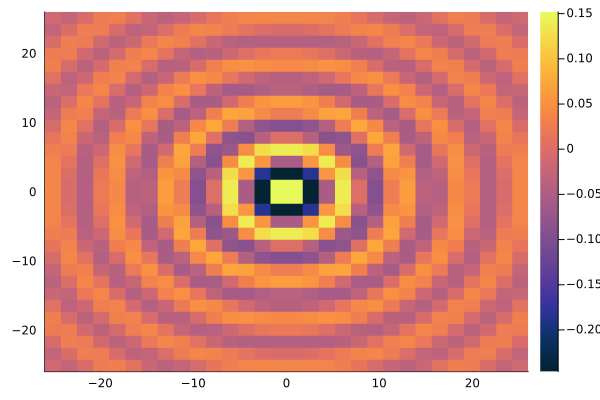

In [99]:
# Calling heatmap with a functiion
fdummy(x, y)= cos(sqrt(x^2 + y^2)) / (1 + sqrt(x^2 + y^2))
x = range(-8π, 8π, length = 30)
heatmap(x, x, fdummy, c = :thermal)

In [62]:
usdData=deepcopy(dataB[dataB.assetID.=="NCM/AEHR",:])
usdData[!,:assetID].="FEX/USD"
usdData[!,:exchangeName].="FEX"
usdData[!,:symbol].="USD"
usdData[!,[:close,:high,:low,:open]].=1.0
usdData[!,[:volume]].=0
vcat(dataB,usdData)


Row,close,high,low,open,volume,date,unix,exchangeName,timezone,currency,symbol,assetID
,Float64,Float64,Float64,Float64,Int64,DateTime,Int64,String,String,String,String,String
1,2.38,2.4,2.25,2.34,25500,2017-01-03T10:30:00,1483453800,NCM,America/New_York,USD,AEHR,NCM/AEHR
2,2.32,2.38,2.24,2.34,23300,2017-01-04T10:30:00,1483540200,NCM,America/New_York,USD,AEHR,NCM/AEHR
3,2.3,2.63,2.24,2.35,64100,2017-01-05T10:30:00,1483626600,NCM,America/New_York,USD,AEHR,NCM/AEHR
4,2.34,2.37,2.3,2.3,47800,2017-01-06T10:30:00,1483713000,NCM,America/New_York,USD,AEHR,NCM/AEHR
5,2.37,2.45,2.32,2.32,7700,2017-01-09T10:30:00,1483972200,NCM,America/New_York,USD,AEHR,NCM/AEHR
6,2.37,2.42,2.35,2.35,18000,2017-01-10T10:30:00,1484058600,NCM,America/New_York,USD,AEHR,NCM/AEHR
7,2.46,2.47,2.37,2.37,16400,2017-01-11T10:30:00,1484145000,NCM,America/New_York,USD,AEHR,NCM/AEHR
8,2.48,2.52,2.48,2.48,3000,2017-01-12T10:30:00,1484231400,NCM,America/New_York,USD,AEHR,NCM/AEHR
9,2.52,2.59,2.45,2.45,10800,2017-01-13T10:30:00,1484317800,NCM,America/New_York,USD,AEHR,NCM/AEHR
